In [1]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import random as rand
import matplotlib.pyplot as plt
import cmath as cm
from IPython.display import display, Latex

In [467]:
# defininsg coefficeients sybols

def Creating_states( coeff = [1/(2**.5),1/(2**.5),1/(2**.5),1/(2**.5)] , Abstract = False):    # coeff list like [a0,a1,b0,b1]
    if Abstract == True:
        a0 = sym.symbols('a0')
        a1 = sym.symbols('a1')
        b0 = sym.symbols('b0')
        b1 = sym.symbols('b1')
    else:
        a0 = coeff[0]
        a1 = coeff[1]
        b0 = coeff[2]
        b1 = coeff[3]
    psi0 = [a0,a1]      # defining states
    psi1 = [b0,b1]
    return([psi0,psi1])


initial_states = Creating_states(Abstract=False, coeff = [1/(2**.5),1/(2**.5),1,0])     # Creating the two states with these coefficients

psi0 = initial_states[0]
psi1 = initial_states[1]

psi0sq = []
psi1sq = []
[[psi0sq.append(i*j) for i in psi0] for j in psi0]
[[psi1sq.append(i*j) for i in psi1] for j in psi1]   # creating list of coeff for squared states (intermeditate step)

psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]        # the second element is the normalized coefficient due to the addition of states (01+10). See OneNote writeup for details
psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]            # symmetric states in basis (|00>, normalized version of (|01>+|10>),|11>)

# psi0psi0
# sum([i**2 for i in psi0psi0])   # adding to 1

In [468]:
# Creating Theoretical density matrix

vec_psi0psi0 = np.array(psi0psi0)     # convertying to numpy arrays
vec_psi1psi1 = np.array(psi1psi1)

rho = (1/2)*(np.outer(vec_psi0psi0, vec_psi0psi0)+np.outer(vec_psi1psi1, vec_psi1psi1))       # density matrix with priors 1/2 each.

print(' Rho matrix : \n' ,rho)

 Rho matrix : 
 [[0.625     0.1767767 0.125    ]
 [0.1767767 0.25      0.1767767]
 [0.125     0.1767767 0.125    ]]


In [469]:
# creating the SIC POVM matrices
w = m.e**((2/3)*m.pi*(1j))     # the w in the notes
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrices

# sum([np.trace(POVM_elts[i]) for i in range(9)])     # trace sum = 3 = Tr(Identity_(3X3)) , verified   

prob_vec_raw =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)]  #[(POVM_elts[i]*rho).trace() for i in range(len(POVM_elts))]
prob_vec = [i.real for i in prob_vec_raw if abs(i.imag) < .01]          # cleaned up the trailing imaginary parts

sum(prob_vec)        # sum prob = 1, verified

0.9999999999999994

In [470]:
#Experimental part

N = 10000       # number of measurements  

POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']       # symbols to indicate collapsed direction
#prob distribution is simply the corresponding elements of the prob_vec
collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   #choosing collapse directions with weights for N trials

nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
pj_num_vec = [i/N for i in nj_vec]      

# ([i*N for i in prob_vec] , nj_vec)   # comparing the theoretical and experimental collapse probabilities, verified


In [471]:
# finding r vector
M = [[np.trace(np.dot(POVM_elts[i],POVM_elts[j])) for i in range(len(POVM_elts))] for j in range(len(POVM_elts))]     # creating M matrix using POVM definition

u_0 = [1/3 for i in range(9)]           # cerating u_0 vector, to create the inverse matrix
M_inv = 3*np.outer(u_0,u_0) + 12*(np.eye(9) - np.outer(u_0,u_0))        # creating the inverse matrix
# np.trace(np.dot(M,M_inv))       # gives identity, checks out
r_vec = np.dot(M_inv,pj_num_vec)


In [472]:
#Reconstructing numerical rho
rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in notes pair_disc.pdf

rho_num = np.zeros_like(rho_num_list[0])

# Loop over the matrices and sum them element-wise to find the numerically reconstructed rho
for matrix in rho_num_list:
    rho_num = np.add(rho_num, matrix)

print('Numerical rho:\n', rho_num)   

Numerical rho:
 [[0.625 +0.00000000e+00j 0.1818-6.23538291e-03j 0.1147-5.36935750e-03j]
 [0.1818+6.23538291e-03j 0.2624+3.50904437e-18j 0.1782-1.03923048e-03j]
 [0.1147+5.36935750e-03j 0.1782+1.03923048e-03j 0.1126+2.28009036e-18j]]


In [473]:
#Error Stuff   
del_rho = rho_num-rho  # defining the difference of numberical and theoretical state
# del_rho

eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
# eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue

# norm_del_rho    # "error in the density matrices"

Pretty much everything above combined into a function for the sake of ease

In [490]:
#Creating function for the sake of ease, for the error in the density matrices. This plots 
def experiment_rho(N = 10000, coeff = [1,0,0,1], priors = [.5,.5], show_calcs = False):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [round(i.real, 5) for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num_raw = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num_raw = np.add(rho_num_raw, matrix)       # created the numerical rho
    
    rho_num = np.real_if_close(np.around(rho_num_raw, decimals=5))
    del_rho = rho_num-rho 
    
    eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
    # eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])    # cleaning up
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))

    norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue
    error = norm_del_rho

    if show_calcs == True:
        # Display states in LateX
        latex_psi0 = r'\Psi_0 = {}|0\rangle + {}|1\rangle'.format(psi0[0],psi0[1])
        latex_psi1 = r'\Psi_1 = {}|0\rangle + {}|1\rangle'.format(psi1[0],psi1[1])
        display(Latex(f'${latex_psi0}$'))
        display(Latex(f'${latex_psi1}$'))

        # Printing other parameters
        print('\n Rho_Theorectical = \n', rho)

        print('\n Prob_theory = ', prob_vec)
        print('Prob_numerical = ', pj_num_vec)

        print('Rho_Numerical_raw = \n', rho_num_raw )
        print('\n Rho_Numerical = \n', rho_num )
        
        print('\nDifference (rho-rho_num) = \n ', del_rho )
        
        print('\n evals of del_rho= \n ', evals)
        print('\n evecs of del_rho= \n ', evecs)
        
        spectral_reconstruction_DelRho = evals[0]*np.outer(evecs[:,0], evecs[:,0])+evals[1]*np.outer(evecs[:,1], evecs[:,1])+evals[2]*np.outer(evecs[:,2], evecs[:,2])  # verifying spectral decomposition, and that indeed the columns r the evecs
        print('Spectra_reconstruction = \n',spectral_reconstruction_DelRho)
        
        print('\n largest mod eval (error) =' , error)
    return [error, rho, rho_num, evals, evecs]

# experiment_rho(10000, [1,0,0,1],[.5,.5], True)     # Example. prints intermediate quantites for analysis.


The cell below has example how eigenvectors change drastically for different trials with the exact same initial parameters. Is it coz
these are evectors of the difference matrix - and this fluctuates randomly bw negative/positive for each entry - thus making evectors of this 
matrix quite sensitve to random fluctuations.

In [475]:
# prinintng evector matrix of the difference matrix delta rho.

print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])





[[ 0.49408+0.j       0.00476+0.00055j -0.00115-0.00126j]
 [ 0.00476-0.00055j  0.0051 +0.j       0.00456-0.00197j]
 [-0.00115+0.00126j  0.00456+0.00197j  0.50082+0.j     ]]



[[ 5.0196e-01+0.j      -1.0000e-04+0.00333j  1.6800e-03-0.00152j]
 [-1.0000e-04-0.00333j  3.1000e-03-0.j      -1.1800e-03-0.0017j ]
 [ 1.6800e-03+0.00152j -1.1800e-03+0.0017j   4.9494e-01+0.j     ]]



[[ 5.0246e-01+0.00e+00j  1.0000e-05+9.00e-05j  8.0000e-05+2.81e-03j]
 [ 1.0000e-05-9.00e-05j -3.1200e-03-0.00e+00j -7.1000e-04+1.58e-03j]
 [ 8.0000e-05-2.81e-03j -7.1000e-04-1.58e-03j  5.0066e-01+0.00e+00j]]



[[ 0.49974+0.j      -0.00142+0.00094j  0.00582-0.00419j]
 [-0.00142-0.00094j  0.00664-0.j      -0.00088+0.00239j]
 [ 0.00582+0.00419j -0.00088-0.00239j  0.49362+0.j     ]]



[[ 0.50142+0.j      -0.00129-0.00199j  0.00512-0.00322j]
 [-0.00129+0.00199j -0.00366+0.j      -0.00187-0.00161j]
 [ 0.00512+0.00322j -0.00187+0.00161j  0.50224+0.j     ]]



[[ 0.50396+0.j       0.00098-0.00225j  0.0025 -0.00194j]
 [

In [476]:
# defining solving the quadratic equation fn
def solve_quadratic(a, b, c):
    d = (b**2) - (4*a*c)
    sol1 = (-b-np.sqrt(d))/(2*a)
    sol2 = (-b+np.sqrt(d))/(2*a)
    return [sol1, sol2]

In [477]:
"""

def fid( N = 1000,c = [1,0,0,1], p = [.5,.5]):
    rho = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[1]
    rho_expt = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[2]
    eigenvalues, eigenvectors = np.linalg.eig(rho_expt) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))
    min_eval = np.min([abs(i) for i in evals])
    xi = evecs[:, np.argmin([abs(i) for i in evals])]     # xi vector is same as the vector corresponding to the minimum eval
    c00,c01,c11 = xi[0],xi[1],xi[2]
    z_a,z_b =solve_quadratic(c00, 2*c01, c11)[0], solve_quadratic(c00, 2*c01, c11)[1]
    a0,a1 = (abs(z_a)/(np.sqrt(1+abs(z_a)**2))), (1/(np.sqrt(1+abs(z_a)**2)))
    b0,b1 = (abs(z_b)/(np.sqrt(1+abs(z_b)**2))), (1/(np.sqrt(1+abs(z_b)**2)))
    c_num = [a0,a1,b0,b1]
    F_a = sum([c[i]*c_num[i] for i in range(2)])
    F_b = sum([c[i]*c_num[i] for i in range(2,4)])
    return [[xi], [z_a,z_b], c, c_num, [F_a,F_b]]

"""

'\n\ndef fid( N = 1000,c = [1,0,0,1], p = [.5,.5]):\n    rho = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[1]\n    rho_expt = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[2]\n    eigenvalues, eigenvectors = np.linalg.eig(rho_expt) \n    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])\n    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))\n    min_eval = np.min([abs(i) for i in evals])\n    xi = evecs[:, np.argmin([abs(i) for i in evals])]     # xi vector is same as the vector corresponding to the minimum eval\n    c00,c01,c11 = xi[0],xi[1],xi[2]\n    z_a,z_b =solve_quadratic(c00, 2*c01, c11)[0], solve_quadratic(c00, 2*c01, c11)[1]\n    a0,a1 = (abs(z_a)/(np.sqrt(1+abs(z_a)**2))), (1/(np.sqrt(1+abs(z_a)**2)))\n    b0,b1 = (abs(z_b)/(np.sqrt(1+abs(z_b)**2))), (1/(np.sqrt(1+abs(z_b)**2)))\n    c_num = [a0,a1,b0,b1]\n    F_a = sum([c[i]*c_num[i] for i in range(2)])\n    F_b = sum([c[i]*c_num[i] for i in range(2,4)])\n    retur

In [622]:
def fid( N = 1000,c = [1,0,0,1], p = [.5,.5], threshold = .05):
    rho = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[1]
    rho_expt = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[2]
    eigenvalues, eigenvectors = np.linalg.eig(rho_expt) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))
    min_eval = np.min([abs(i) for i in evals])
    xi = evecs[:, np.argmin([abs(i) for i in evals])]     # xi vector is same as the vector corresponding to the minimum eval
    c00,c01,c11 = xi[0],xi[1],xi[2]

    # print('evals=', evals )
    # print('evecs=', evecs)
    # print('min eval=', min_eval)
    
    
    # if abs(c00) > .05 and abs(c11) > .05:
    #     z_a,z_b =solve_quadratic(c00, 2*c01, c11)[0], solve_quadratic(c00, 2*c01, c11)[1]
    #     a0,a1 = (abs(z_a)/(np.sqrt(1+abs(z_a)**2))), (1/(np.sqrt(1+abs(z_a)**2)))
    #     b0,b1 = (abs(z_b)/(np.sqrt(1+abs(z_b)**2))), (1/(np.sqrt(1+abs(z_b)**2)))
    # elif abs(c00) < .05 and abs(c11) > .05:
    #     a0, a1 = 1,0        # random choice, matching later
    #     z = (-c11)/(2*c01)
    #     b0, b1 = (abs(z)/(np.sqrt(1+abs(z)**2))), (1/(np.sqrt(1+abs(z)**2)))
    # elif abs(c00) > .05 and abs(c11) < .05:
    #     a0, a1 = 0,1        
    #     z = (-2*c01)/(c00)
    #     b0, b1 = (abs(z)/(np.sqrt(1+abs(z)**2))), (1/(np.sqrt(1+abs(z)**2)))
    # elif abs(c00) < .05 and abs(c11) < .05:
    #     a0, a1 = 0,1        
    #     b0, b1 = 1,0     

    if abs(c00) > threshold and abs(c11) > threshold:
        z_a,z_b =solve_quadratic(c00, 2*c01, c11)[0], solve_quadratic(c00, 2*c01, c11)[1]
        a1 = (1/(np.sqrt(1+abs(z_a)**2)))
        a0 = np.conj(z_a)*a1
        b1 = (1/(np.sqrt(1+abs(z_b)**2)))
        b0 = np.conj(z_b)*b1
        print('z_a, z_b = ',z_a, z_b)
    elif abs(c00) < threshold and abs(c11) > threshold:
        a0, a1 = 1,0        # random choice, matching later
        z = np.conj((-c11)/(2*c01))     # z defined as (a0*/a1*)
        b1= (1/(np.sqrt(1+abs(z)**2))) 
        b0= np.conj(z)*b1
        print('condition #2, z = ',z)
    elif abs(c00) > threshold and abs(c11) < threshold:
        a0, a1 = 0,1        
        z = np.conj((-2*c01)/(c00))      # z defined as (b0*/b1*)
        b1= (1/(np.sqrt(1+abs(z)**2))) 
        b0= np.conj(z)*b1
        print('condition #3, z = ',z)
    elif abs(c00) < threshold and abs(c11) < threshold:
        a0, a1 = 0,1        
        b0, b1 = 1,0     

    print('xi', xi)

    c_raw = [a0,a1,b0,b1]
    c_raw = [np.round(i,6) for i in c_raw]

    theta_00 = np.arccos((c_raw[0]*c[0]+c_raw[1]*c[1]))
    theta_11 = np.arccos((c_raw[0]*c[2]+c_raw[1]*c[3]))

    print('c_unassigned  = \n', c_raw )
    print('thetas =', theta_00, theta_11 )

    if abs(theta_00) < abs(theta_11):
        c_num = c_raw
    else:
        c_num = [c_raw[2],c_raw[3],c_raw[0],c_raw[1]]

    print('c_num= \n', c_num )
    print('c_orig= \n', c )

    # F_a = (sum([c[i]*c_num[i] for i in range(2)]))**2
    # F_b = (sum([c[i]*c_num[i] for i in range(2,4)]))**2
    
    F_a = (abs(sum([np.conj(c[i])*c_num[i] for i in range(0,2)])))**2
    F_b = (abs(sum([np.conj(c[i])*c_num[i] for i in range(2,4)])))**2
    

    # print('theta', [theta_00,theta_11])
    # print('c raw', c_raw)
    # print('\n \n')
    # print('Fidelity', [F_a,F_b])
    # print('Theoretical', c)

    # print('Numeriacl', c_num)

    # return [[xi], '', c , c_num, [F_a,F_b]]



In [620]:
(1/(5)**(.5))
# (4/(5)**(.5))

0.4472135954999579

In [634]:
ce = [-.707,.707,-1,0]
# ce = [.707,.707,0,1]

fid(c=ce, threshold=.05, N = 1000000)

evals= [0.74925127 0.24998834 0.00076039]
evecs= [[ 0.865+0.j    -0.501-0.003j  0.003-0.003j]
 [ 0.409-0.001j  0.703+0.j    -0.583+0.002j]
 [ 0.29 -0.002j  0.505+0.003j  0.813+0.j   ]]
min eval= 0.0007603864865840586
condition #2, z =  (0.6972473690249579-0.0023919292247854477j)
xi [ 0.003-0.003j -0.583+0.002j  0.813+0.j   ]
c_unassigned  = 
 [1, 0, (0.571945+0.001962j), 0.82029]
thetas = 2.3560434901900495 3.141592653589793
c_num= 
 [1, 0, (0.571945+0.001962j), 0.82029]
c_orig= 
 [-0.707, 0.707, -1, 0]


In [479]:
#new
c0s = [1,0,0,1]
c0 = [0,1,1,0]
c1 = [.707,.707,0,1]
c2 = [-.707,.707,0,1]
c3 = [-1,0,.707,.707]
c4 = [(2**.5)/(3**.5),1/(3**.5),.707,.707]         
c5 = [1,0,1,0]   # same states   

cc = [-1,0,.707,.707]
fid(N=100000,c=cc)


[[array([ 0.007+0.005j, -0.588-0.003j,  0.809+0.j   ])],
 '',
 [-1, 0, 0.707, 0.707],
 [0.5668, 0.8239, 1, 0],
 [0.32126224, 0.49984899999999993]]

In [481]:
# Plotting function for both quantities

def Plotting(N = 10000, c = [1,0,0,1], p = [.5,.5], step = 100, metric = 'f', size = [3,3]):        # function to plot error vs trials plot. N,c,p are Number of trials, coefficients and priors
    count = N//step
    trials_list = [step*(i+1) for i in range(count)]    # only works if N is a multiple of 100
    sqrtN = [2.6/((i+1)**.5) for i in trials_list]    #ideal square root shape with a constant multiplied for scaling
    
    if metric == 'f':
        label_0 = r' Fidelity $| \Psi_0 \rangle $'
        label_1 = r' Fidelity $| \Psi_1\rangle$'
        errors_list_0 = [fid(i,c,p)[-1][0] for i in trials_list]
        errors_list_1 = [fid(i,c,p)[-1][1] for i in trials_list]
        convergance = f'Error Coverged to:  , {fid(N, c, p)[-1]}'
    else: 
        label_0 = r'$\Delta \rho$'
        errors_list_0 = [experiment_rho(i, c , p)[0] for i in trials_list]
        convergance = f'Error Coverged to:  , {experiment_rho(N, c, p)}'

    plt.figure(figsize=(size[0],size[1]))
    plt.xlabel(f' {N} (trials)')
    plt.ylabel(r'|\Delta \rho|')

    plt.plot(trials_list, errors_list_0, label=label_0)
    if metric=='f':
        plt.plot(trials_list, errors_list_1, label=label_1)
        plt.ylabel('Fidelity')
    else:
        plt.plot(trials_list,sqrtN, "--", label=r'$\frac{1}{\sqrt{N}}$')
    plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $\eta_1={},\,\eta_2={}$'.format(round(c[0],3), round(c[1],3), round(c[2],3), round(c[3],3), p[0], p[1]))
    plt.legend()
    plt.show()
    
    print(convergance)



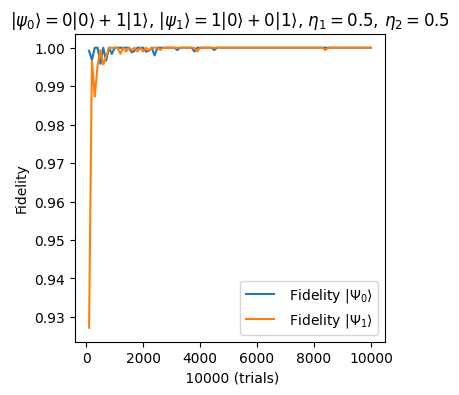

Error Coverged to:  , [1, 1]


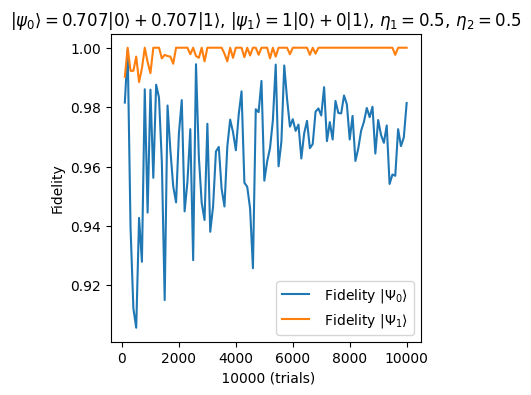

Error Coverged to:  , [0.98446838073444, 1]


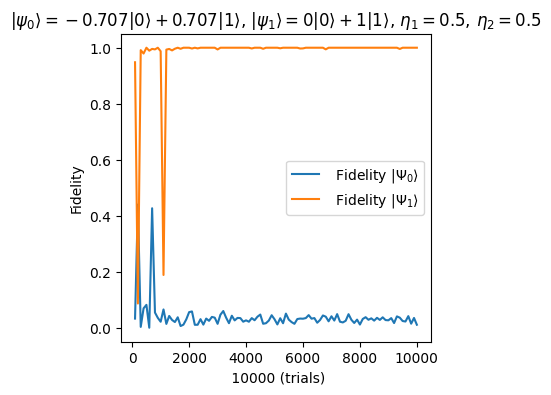

Error Coverged to:  , [0.024923915703609977, 1]


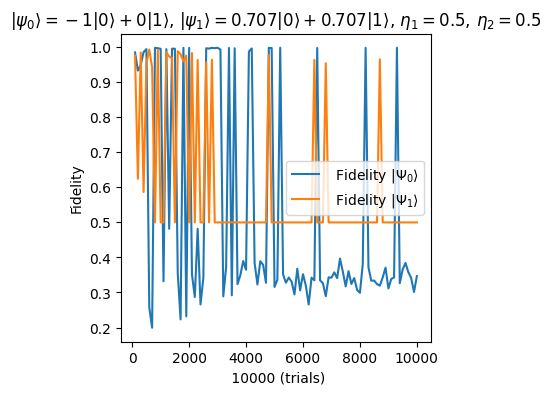

Error Coverged to:  , [0.33977240999999997, 0.49984899999999993]


/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/464324292.py:32: RuntimeWarning: invalid value encountered in arccos
  theta_00 = np.arccos((c_raw[0]*c[0]+c_raw[1]*c[1]))


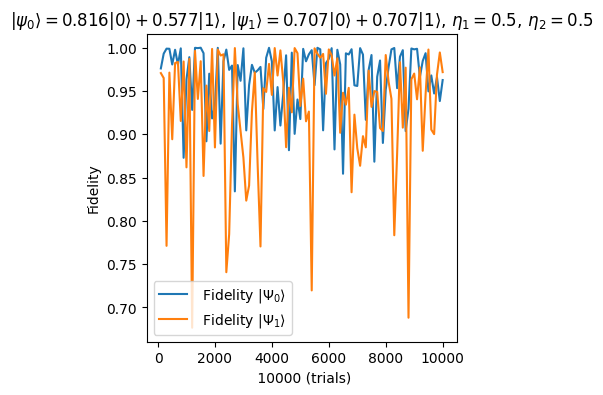

Error Coverged to:  , [0.9970456341800356, 0.9042393372249999]


/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/464324292.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  z = (-c11)/(2*c01)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/464324292.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z = (-c11)/(2*c01)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/464324292.py:20: RuntimeWarning: invalid value encountered in scalar divide
  b0, b1 = (abs(z)/(np.sqrt(1+abs(z)**2))), (1/(np.sqrt(1+abs(z)**2)))


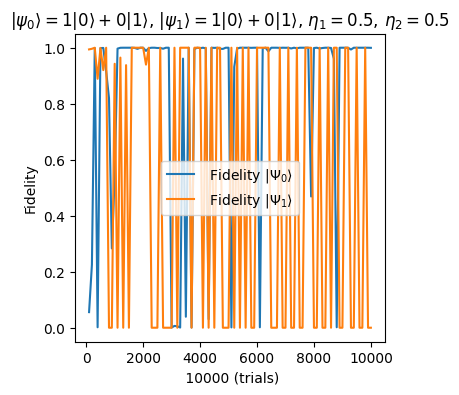

Error Coverged to:  , [nan, 1]


In [489]:
# plots
c0 = [0,1,1,0]
# c1 = [.707,.707,0,1]
c1 = [.707,.707,1,0]
c2 = [-.707,.707,0,1]
c3 = [-1,0,.707,.707]
c4 = [(2**.5)/(3**.5),1/(3**.5),.707,.707]         
c5 = [1,0,1,0]   # same states   

c_l = [c0,c1,c2,c3,c4,c5]
for c in c_l : 
    Plotting(c=c,N= 10000, step= 100, size=[4,4])